<a href="https://colab.research.google.com/github/CalculatedContent/xgboost2ww/blob/main/notebooks/XGBWW_Catalog_Random100_XGBoost_Accuracy_WithOverfitCatalog.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What this notebook does

This notebook benchmarks **XGBoost classification accuracy** across a random sample of catalog datasets, then intentionally trains **overfit variants per completed dataset** to make failure modes visible.

## End-to-end workflow
1. Load `dataset_catalog.csv` from Drive and keep classification tasks.
2. Sample datasets with a fixed random seed and persist the selected list.
3. Train one baseline (“good”) model per sampled dataset.
4. For each completed baseline dataset, train one model per selected overfit mode (`OVERFIT_MODES[:MAX_OVERFIT_CASES]`).
5. Run `xgboost2ww` conversion + WeightWatcher metrics for both baseline and overfit runs.
6. Save checkpoint files continuously so interrupted runs can resume.
7. Write an aggregated output table containing both `case_type="good"` and `case_type="overfit"` rows.

## Overfit behavior in this notebook
- Overfit modes are configured by `OVERFIT_MODES` and capped by `MAX_OVERFIT_CASES` (default 6).
- Modes are applied **per completed dataset** (not globally across only a few datasets).
- Default modes:
  1. `deep_trees`
  2. `too_many_rounds`
  3. `no_regularization`
  4. `no_subsampling`
  5. `tiny_trainset`
  6. `leakage`

## Runtime logging you will see
- Baseline pass: dataset index progress (`[i/N]`), dataset UID, and final `train_accuracy` / `test_accuracy`.
- Overfit pass: dataset index progress (`[dataset i/N]`), overfit mode index (`[overfit j/M]`), overfit mode name, and final `train_accuracy` / `test_accuracy`.
- Skip/failure messages for datasets or modes that cannot be trained.

## Expected outputs
- `checkpoint_results.csv`: running status and per-run metrics.
- `errors.csv`: failed/model_failed rows.
- `results_per_dataset.csv`: completed baseline rows.
- `results_summary_by_source.csv`: baseline source-level summary.
- `checkpoint_results_good_plus_overfit.csv`: aggregated baseline + overfit rows.
- `experiment_config.json`: experiment settings and counts.

## Why include overfit cases?
Including overfit runs alongside strong baseline models provides a direct comparison target for diagnostic plots and sanity checks on generalization behavior.



# XGBWW catalog-driven random-per-source XGBoost benchmark + targeted overfit cases

This notebook keeps the original catalog benchmark workflow, then adds intentionally overfit models per dataset (5–6 cases per dataset, based on `OVERFIT_MODES[:MAX_OVERFIT_CASES]`) and writes an aggregated checkpoint with both good and overfit results.


## 1) Mount Google Drive and configure paths


In [78]:
from google.colab import drive
from pathlib import Path
import json
import pandas as pd

# ===== USER CONFIG =====
CATALOG_CSV = Path("/content/drive/MyDrive/xgbwwdata/catalog_checkpoint/dataset_catalog.csv")
RANDOM_SEED = 42
RANDOM_SAMPLE_SIZE = 100
TEST_SIZE = 0.20
EXPERIMENT_ROOT = Path("/content/drive/MyDrive/xgbwwdata/experiment_checkpoints")
DEFAULT_EXPERIMENT_BASENAME = "random100_xgboost_accuracy_plus_overfit"

# Targeted overfit cases
OVERFIT_MODES = [
    "deep_trees",
    "too_many_rounds",
    "no_regularization",
    "no_subsampling",
    "tiny_trainset",
    "leakage",
]
MAX_OVERFIT_CASES = 6
TINY_TRAIN_FRAC = 0.05

# Restart control
RESTART_EXPERIMENT = True
RETRY_FAILED_DATASETS = False  # Default: do not retry failed/model_failed datasets on restart.
EXPERIMENT_NAME = "random100_xgboost_accuracy_plus_overfit_run04" # Required for restart.
AUTO_INCREMENT_IF_NAME_MISSING = True
# =======================


def next_experiment_name(root: Path, base_name: str) -> str:
    existing = [d.name for d in root.glob(f"{base_name}_run*") if d.is_dir()]
    nums = []
    for name in existing:
        suffix = name.replace(f"{base_name}_run", "")
        if suffix.isdigit():
            nums.append(int(suffix))
    n = (max(nums) + 1) if nums else 1
    return f"{base_name}_run{n:02d}"


drive.mount("/content/drive")
EXPERIMENT_ROOT.mkdir(parents=True, exist_ok=True)

if RESTART_EXPERIMENT:
    if not EXPERIMENT_NAME:
        raise ValueError("Set EXPERIMENT_NAME when RESTART_EXPERIMENT=True.")
    EXPERIMENT_ID = EXPERIMENT_NAME
else:
    if EXPERIMENT_NAME:
        EXPERIMENT_ID = EXPERIMENT_NAME
    elif AUTO_INCREMENT_IF_NAME_MISSING:
        EXPERIMENT_ID = next_experiment_name(EXPERIMENT_ROOT, DEFAULT_EXPERIMENT_BASENAME)
    else:
        EXPERIMENT_ID = DEFAULT_EXPERIMENT_BASENAME

CHECKPOINT_DIR = EXPERIMENT_ROOT / EXPERIMENT_ID
CHECKPOINT_DIR.mkdir(parents=True, exist_ok=True)

CHECKPOINT_RESULTS_CSV = CHECKPOINT_DIR / "checkpoint_results.csv"
CHECKPOINT_ERRORS_CSV = CHECKPOINT_DIR / "errors.csv"
CHECKPOINT_AGGREGATED_CSV = CHECKPOINT_DIR / "checkpoint_results_good_plus_overfit.csv"
SELECTED_DATASETS_CSV = CHECKPOINT_DIR / "selected_datasets.csv"
EXPERIMENT_CONFIG_JSON = CHECKPOINT_DIR / "experiment_config.json"

print("Catalog path:", CATALOG_CSV)
print("Experiment checkpoint:", CHECKPOINT_DIR)
print("Restart mode:", RESTART_EXPERIMENT)




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Catalog path: /content/drive/MyDrive/xgbwwdata/catalog_checkpoint/dataset_catalog.csv
Experiment checkpoint: /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_plus_overfit_run04
Restart mode: True


## How far did we get before ?


In [79]:
# Progress snapshot from Google Drive checkpoint.
# Restart behavior:
# - status == "completed" is always skipped
# - failed/model_failed are retried only when RETRY_FAILED_DATASETS=True
# - pending/missing are always run
selected_df = pd.read_csv(SELECTED_DATASETS_CSV) if SELECTED_DATASETS_CSV.exists() else None
checkpoint_df = pd.read_csv(CHECKPOINT_RESULTS_CSV) if CHECKPOINT_RESULTS_CSV.exists() else pd.DataFrame()

if selected_df is not None and "dataset_uid" in selected_df.columns:
    target_uids = selected_df["dataset_uid"].astype(str).tolist()
else:
    target_uids = checkpoint_df.get("dataset_uid", pd.Series(dtype=str)).astype(str).tolist()
    if not target_uids:
        target_uids = [None] * RANDOM_SAMPLE_SIZE

status_by_uid = {}
if not checkpoint_df.empty and "dataset_uid" in checkpoint_df.columns:
    checkpoint_df = checkpoint_df.drop_duplicates(subset=["dataset_uid"], keep="last")
    if "status" in checkpoint_df.columns:
        status_by_uid = dict(zip(checkpoint_df["dataset_uid"].astype(str), checkpoint_df["status"].astype(str)))

completed_models = 0
remaining_models = 0
next_uid = None
next_index = None

for idx, uid in enumerate(target_uids, start=1):
    uid_key = str(uid) if uid is not None else None
    status = status_by_uid.get(uid_key, "missing")

    if status == "completed":
        completed_models += 1
        should_run = False
    elif status in {"failed", "model_failed"}:
        should_run = RETRY_FAILED_DATASETS
    else:
        should_run = True

    if should_run:
        remaining_models += 1
        if next_uid is None:
            next_uid = uid_key
            next_index = idx

failed_statuses = {"failed", "model_failed"}
failed_models = sum(1 for uid in target_uids if status_by_uid.get(str(uid), "missing") in failed_statuses)

print(f"Total selected models: {len(target_uids)}")
print(f"Completed models: {completed_models}")
print(f"Failed models currently on checkpoint: {failed_models}")
print(f"Retry failed datasets on restart: {RETRY_FAILED_DATASETS}")
print(f"Remaining models to run on restart: {remaining_models}")
if next_uid is not None:
    print(f"Restart will resume at dataset #{next_index}: {next_uid}")
else:
    print("Checkpoint is fully completed. No more models remain.")

Total selected models: 100
Completed models: 0
Failed models currently on checkpoint: 0
Retry failed datasets on restart: False
Remaining models to run on restart: 100
Checkpoint is fully completed. No more models remain.


## 2) Install dependencies

Use the same repository-install flow as the other Colab notebooks (no `pip install xgbwwdata`).


In [80]:
# Install xgbwwdata from a fresh clone using the repository installer script
!rm -rf /content/repo_xgbwwdata
!git clone https://github.com/CalculatedContent/xgbwwdata.git /content/repo_xgbwwdata
%run /content/repo_xgbwwdata/scripts/colab_install.py --repo /content/repo_xgbwwdata

# Notebook-specific dependencies
%pip install -q openml pmlb keel-ds xgboost scikit-learn xgboost2ww weightwatcher


Cloning into '/content/repo_xgbwwdata'...
remote: Enumerating objects: 146, done.
remote: Counting objects: 100% (46/46), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 146 (delta 12), reused 0 (delta 0), pack-reused 100 (from 2)
Receiving objects: 100% (146/146), 240.36 KiB | 3.08 MiB/s, done.
Resolving deltas: 100% (49/49), done.
+ /usr/bin/python3 -m pip install -U pip setuptools wheel
+ /usr/bin/python3 -m pip install -r /content/repo_xgbwwdata/requirements.txt
+ /usr/bin/python3 -m pip install -e /content/repo_xgbwwdata --no-build-isolation --no-deps
module: <module 'xgbwwdata' from '/content/repo_xgbwwdata/src/xgbwwdata/__init__.py'>
__file__: /content/repo_xgbwwdata/src/xgbwwdata/__init__.py
__path__: ['/content/repo_xgbwwdata/src/xgbwwdata']
exports: ['Filters', 'ScanOptions', 'config', 'enable_logging', 'load_dataset', 'logging', 'registry', 'scan_datasets', 'sources']
import OK


<Figure size 640x480 with 0 Axes>

## 3) Imports


In [81]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import xgboost as xgb
import weightwatcher as ww

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from xgbwwdata import Filters, load_dataset
from xgboost2ww import convert


## 4) Load catalog and pick 100 random dataset UIDs (checkpoint-aware)


In [82]:
if not CATALOG_CSV.exists():
    raise FileNotFoundError(f"Catalog not found: {CATALOG_CSV}. Run XGBWW_Dataset_Catalog_Checkpoint.ipynb first.")

df_catalog = pd.read_csv(CATALOG_CSV)
print("Catalog shape:", df_catalog.shape)

required_cols = {"dataset_uid", "source", "task_type"}
missing = required_cols - set(df_catalog.columns)
if missing:
    raise ValueError(f"Catalog is missing required columns: {missing}")

# Accuracy is for classification; keep classification-like tasks
df_cls = df_catalog[df_catalog["task_type"].astype(str).str.contains("classification", case=False, na=False)].copy()
if df_cls.empty:
    raise ValueError("No classification datasets found in catalog.")

# Select 100 random dataset UIDs up front for this experiment.
n_select = min(RANDOM_SAMPLE_SIZE, len(df_cls))
df_pick = df_cls.sample(n=n_select, random_state=RANDOM_SEED).reset_index(drop=True)

print("Selected datasets:", len(df_pick))
display(df_pick[["source", "dataset_uid", "name", "task_type"]].sort_values(["source", "dataset_uid"]))

# Initialize or reload checkpoint table
if RESTART_EXPERIMENT and CHECKPOINT_RESULTS_CSV.exists():
    checkpoint_df = pd.read_csv(CHECKPOINT_RESULTS_CSV)
    print(f"Loaded existing checkpoint rows: {len(checkpoint_df)}")
else:
    checkpoint_df = df_pick.copy()
    checkpoint_df["status"] = "pending"
    checkpoint_df["error_message"] = ""

    # model / hyperparameter fields (blank at initialization)
    checkpoint_df["xgboost_params"] = ""
    checkpoint_df["rounds"] = np.nan
    checkpoint_df["n_classes"] = np.nan
    checkpoint_df["train_size"] = np.nan
    checkpoint_df["test_size_rows"] = np.nan

    # train/test accuracy fields
    checkpoint_df["train_accuracy"] = np.nan
    checkpoint_df["test_accuracy"] = np.nan

    # weightwatcher metrics
    checkpoint_df["alpha"] = np.nan
    checkpoint_df["ERG_gap"] = np.nan
    checkpoint_df["num_traps"] = np.nan

    # metadata from actual loaded data
    checkpoint_df["dataset_name"] = checkpoint_df.get("name", "")
    checkpoint_df["dataset_openml_id"] = checkpoint_df.get("openml_data_id", np.nan)
    checkpoint_df["n_rows"] = np.nan
    checkpoint_df["n_features"] = np.nan
    checkpoint_df["test_size"] = TEST_SIZE

# Ensure the selected datasets are saved for restart reproducibility
if not SELECTED_DATASETS_CSV.exists():
    df_pick.to_csv(SELECTED_DATASETS_CSV, index=False)

# If restarting, trust existing selected datasets file when present
if RESTART_EXPERIMENT and SELECTED_DATASETS_CSV.exists():
    df_pick = pd.read_csv(SELECTED_DATASETS_CSV)

# Save initial checkpoint immediately
checkpoint_df.to_csv(CHECKPOINT_RESULTS_CSV, index=False)
print("Checkpoint file:", CHECKPOINT_RESULTS_CSV)


Catalog shape: (1376, 11)
Selected datasets: 100


,source,dataset_uid,name,task_type
95,keel,keel:banana,banana,classification
59,keel,keel:bupa,bupa,classification
97,openml,openml:1011,ecoli,classification
62,openml,openml:1022,mfeat-pixel,classification
50,openml,openml:1024,cjs,classification
...,...,...,...,...
80,openml,openml:986,analcatdata_marketing,classification
44,openml,openml:990,eucalyptus,classification
99,pmlb,pmlb:GAMETES_Epistasis_2_Way_20atts_0.1H_EDM_1_1,GAMETES_Epistasis_2_Way_20atts_0.1H_EDM_1_1,classification
49,pmlb,pmlb:GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,classification


Checkpoint file: /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_plus_overfit_run04/checkpoint_results.csv


## 5) Train one XGBoost model per sampled dataset, run xgboost2ww + WeightWatcher, and report metrics


In [83]:
filters = Filters(
    min_rows=200,
    max_rows=60000,
    max_features=50000,
    max_dense_elements=int(2e8),
)


class ModelTrainingFailed(RuntimeError):
    """Raised when XGBoost model fitting fails for a dataset."""


def detect_xgb_compute_params():
    """Prefer CUDA in Colab when available; gracefully fall back to CPU."""
    gpu_params = {"tree_method": "hist", "device": "cuda"}
    cpu_params = {"tree_method": "hist"}

    X_probe = np.array([[0.0], [1.0], [2.0], [3.0]], dtype=np.float32)
    y_probe = np.array([0, 0, 1, 1], dtype=np.float32)
    dprobe = xgb.DMatrix(X_probe, label=y_probe)

    try:
        xgb.train(
            params={
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                **gpu_params,
            },
            dtrain=dprobe,
            num_boost_round=1,
            verbose_eval=False,
        )
        return gpu_params, "gpu"
    except Exception:
        return cpu_params, "cpu"


def apply_overfit_mode(params: dict, mode: str, seed: int):
    p = dict(params)
    rng = np.random.default_rng(seed + 999)

    if mode == "deep_trees":
        p["max_depth"] = int(rng.integers(12, 19))
        p["learning_rate"] = float(rng.uniform(0.2, 0.45))
        p["min_child_weight"] = float(rng.uniform(1.0, 4.0))
        p["reg_lambda"] = 0.0
        p["reg_alpha"] = 0.0
    elif mode == "too_many_rounds":
        p["learning_rate"] = float(rng.uniform(0.25, 0.5))
        p["max_depth"] = int(rng.integers(6, 12))
        p["subsample"] = 1.0
        p["colsample_bytree"] = 1.0
    elif mode == "no_regularization":
        p["reg_lambda"] = 0.0
        p["reg_alpha"] = 0.0
        p["gamma"] = 0.0
        p["max_depth"] = int(rng.integers(7, 13))
        p["learning_rate"] = float(rng.uniform(0.2, 0.45))
    elif mode == "no_subsampling":
        p["subsample"] = 1.0
        p["colsample_bytree"] = 1.0
        p["max_depth"] = int(rng.integers(6, 11))
        p["learning_rate"] = float(rng.uniform(0.2, 0.45))
    elif mode == "tiny_trainset":
        p["max_depth"] = int(rng.integers(9, 15))
        p["learning_rate"] = float(rng.uniform(0.25, 0.5))
        p["subsample"] = 1.0
        p["colsample_bytree"] = 1.0
    elif mode == "leakage":
        p["max_depth"] = int(rng.integers(5, 10))
        p["learning_rate"] = float(rng.uniform(0.2, 0.45))
        p["subsample"] = 1.0
        p["colsample_bytree"] = 1.0
    else:
        raise ValueError(f"Unknown overfit mode: {mode}")
    return p


def training_schedule(case_type: str, overfit_mode: str | None):
    if case_type == "overfit" and overfit_mode == "too_many_rounds":
        return 7000, None
    if case_type == "overfit":
        return 3000, None
    return 1200, None


XGB_COMPUTE_PARAMS, XGB_COMPUTE_BACKEND = detect_xgb_compute_params()
print(f"XGBoost compute backend detected: {XGB_COMPUTE_BACKEND} | params={XGB_COMPUTE_PARAMS}")


def fit_and_score(row_data: dict, case_type: str = "good", overfit_mode: str | None = None, seed_offset: int = 0):
    dataset_uid = row_data["dataset_uid"]
    source = row_data["source"]
    local_seed = RANDOM_SEED + seed_offset

    X, y, meta = load_dataset(dataset_uid, filters=filters)

    y = np.asarray(y)
    classes, y_enc = np.unique(y, return_inverse=True)
    n_classes = len(classes)
    if n_classes < 2:
        raise ValueError(f"Dataset {dataset_uid} has <2 classes after loading.")

    stratify = y_enc if n_classes > 1 else None
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_enc, test_size=TEST_SIZE, random_state=local_seed, stratify=stratify
    )

    if case_type == "overfit" and overfit_mode == "tiny_trainset":
        sub_idx, _ = train_test_split(
            np.arange(len(y_train)),
            test_size=(1.0 - TINY_TRAIN_FRAC),
            random_state=local_seed,
            stratify=y_train,
        )
        X_train, y_train = X_train[sub_idx], y_train[sub_idx]

    if case_type == "overfit" and overfit_mode == "leakage":
        rng = np.random.default_rng(local_seed)
        Xtr_dense = X_train.toarray() if hasattr(X_train, "toarray") else np.asarray(X_train)
        Xte_dense = X_test.toarray() if hasattr(X_test, "toarray") else np.asarray(X_test)
        leak_tr = (y_train + 0.05 * rng.standard_normal(len(y_train))).astype(np.float32).reshape(-1, 1)
        leak_te = (y_test + 0.05 * rng.standard_normal(len(y_test))).astype(np.float32).reshape(-1, 1)
        X_train = np.hstack([Xtr_dense.astype(np.float32), leak_tr])
        X_test = np.hstack([Xte_dense.astype(np.float32), leak_te])

    dtrain = xgb.DMatrix(X_train, label=y_train)
    dtest = xgb.DMatrix(X_test, label=y_test)

    try:
        if n_classes == 2:
            params = {
                "objective": "binary:logistic",
                "eval_metric": "logloss",
                **XGB_COMPUTE_PARAMS,
                "learning_rate": 0.05,
                "max_depth": 6,
                "subsample": 0.85,
                "colsample_bytree": 0.85,
                "min_child_weight": 2.0,
                "reg_lambda": 2.0,
                "reg_alpha": 0.2,
                "gamma": 0.1,
                "seed": local_seed,
            }
            if case_type == "overfit":
                params = apply_overfit_mode(params, overfit_mode, local_seed)
            num_boost_round, early_stop = training_schedule(case_type, overfit_mode)
            if early_stop is None:
                cv = xgb.cv(
                    params=params,
                    dtrain=dtrain,
                    num_boost_round=num_boost_round,
                    nfold=5,
                    stratified=True,
                    early_stopping_rounds=50,
                    seed=local_seed,
                    verbose_eval=False,
                )
                rounds = len(cv)
                model = xgb.train(params=params, dtrain=dtrain, num_boost_round=rounds, verbose_eval=False)
            else:
                model = xgb.train(
                    params=params,
                    dtrain=dtrain,
                    num_boost_round=num_boost_round,
                    evals=[(dtrain, "train"), (dtest, "test")],
                    early_stopping_rounds=early_stop,
                    verbose_eval=False,
                )
                rounds = int(model.best_iteration + 1)

            yhat_tr = (model.predict(dtrain) >= 0.5).astype(int)
            yhat_te = (model.predict(dtest) >= 0.5).astype(int)
        else:
            params = {
                "objective": "multi:softprob",
                "num_class": n_classes,
                "eval_metric": "mlogloss",
                **XGB_COMPUTE_PARAMS,
                "learning_rate": 0.05,
                "max_depth": 7,
                "subsample": 0.9,
                "colsample_bytree": 0.9,
                "min_child_weight": 1.0,
                "reg_lambda": 1.0,
                "reg_alpha": 0.1,
                "gamma": 0.0,
                "seed": local_seed,
            }
            if case_type == "overfit":
                params = apply_overfit_mode(params, overfit_mode, local_seed)
            num_boost_round, early_stop = training_schedule(case_type, overfit_mode)
            if early_stop is None:
                cv = xgb.cv(
                    params=params,
                    dtrain=dtrain,
                    num_boost_round=num_boost_round,
                    nfold=5,
                    stratified=True,
                    early_stopping_rounds=60,
                    seed=local_seed,
                    verbose_eval=False,
                )
                rounds = len(cv)
                model = xgb.train(params=params, dtrain=dtrain, num_boost_round=rounds, verbose_eval=False)
            else:
                model = xgb.train(
                    params=params,
                    dtrain=dtrain,
                    num_boost_round=num_boost_round,
                    evals=[(dtrain, "train"), (dtest, "test")],
                    early_stopping_rounds=early_stop,
                    verbose_eval=False,
                )
                rounds = int(model.best_iteration + 1)

            yhat_tr = np.argmax(model.predict(dtrain), axis=1)
            yhat_te = np.argmax(model.predict(dtest), axis=1)
    except Exception as e:
        raise ModelTrainingFailed(f"Model training failed for dataset {dataset_uid}: {e}") from e

    ww_layer = convert(
        model,
        X_train,
        y_train,
        W="W7",
        nfolds=5,
        t_points=160,
        random_state=local_seed,
        train_params=params,
        num_boost_round=rounds,
        multiclass="avg" if n_classes > 2 else "error",
        return_type="torch",
    )
    watcher = ww.WeightWatcher(model=ww_layer)
    details_df = watcher.analyze(ERG=True, randomize=True, plot=False)

    alpha = float(details_df["alpha"].iloc[0]) if "alpha" in details_df else np.nan
    erg_gap = float(details_df["ERG_gap"].iloc[0]) if "ERG_gap" in details_df else np.nan
    num_traps = float(details_df["num_traps"].iloc[0]) if "num_traps" in details_df else np.nan

    result = {
        "source": source,
        "dataset_uid": dataset_uid,
        "dataset_name": row_data.get("name", meta.get("name")),
        "task_type": row_data.get("task_type"),
        "dataset_openml_id": row_data.get("openml_data_id"),
        "n_rows": int(meta.get("n_rows", len(y))),
        "n_features": int(meta.get("n_features", X.shape[1] if hasattr(X, "shape") else -1)),
        "n_classes": int(n_classes),
        "test_size": float(TEST_SIZE),
        "train_size": int(len(y_train)),
        "test_size_rows": int(len(y_test)),
        "rounds": int(rounds),
        "train_accuracy": float(accuracy_score(y_train, yhat_tr)),
        "test_accuracy": float(accuracy_score(y_test, yhat_te)),
        "accuracy_gap": float(accuracy_score(y_train, yhat_tr) - accuracy_score(y_test, yhat_te)),
        "alpha": alpha,
        "ERG_gap": erg_gap,
        "num_traps": num_traps,
        "case_type": case_type,
        "overfit_mode": overfit_mode if overfit_mode else "none",
        "seed_used": int(local_seed),
        "xgboost_params": json.dumps(params, sort_keys=True),
        "status": "completed",
        "error_message": "",
    }
    return result


def update_checkpoint_row(uid: str, updates: dict):
    global checkpoint_df
    mask = checkpoint_df["dataset_uid"] == uid
    if not mask.any():
        return
    for k, v in updates.items():
        if k not in checkpoint_df.columns:
            checkpoint_df[k] = np.nan
        checkpoint_df.loc[mask, k] = v
    checkpoint_df.to_csv(CHECKPOINT_RESULTS_CSV, index=False)


total_models = len(df_pick)

for model_idx, row in enumerate(df_pick.itertuples(index=False), start=1):
    row_data = row._asdict()
    uid = row_data["dataset_uid"]
    progress = f"[{model_idx}/{total_models}]"

    existing = checkpoint_df.loc[checkpoint_df["dataset_uid"] == uid, "status"]
    if not existing.empty:
        existing_status = str(existing.iloc[0])
        if existing_status == "completed":
            print(f"{progress} Skipping completed dataset: {uid}")
            continue
        if existing_status in {"failed", "model_failed"} and not RETRY_FAILED_DATASETS:
            print(f"{progress} Skipping failed dataset (retry disabled): {uid}")
            continue

    print(f"{progress} Training + WW analysis: {uid} | case_type=good")
    try:
        result = fit_and_score(row_data, case_type="good", overfit_mode=None, seed_offset=0)
        update_checkpoint_row(uid, result)
        print(
            f"{progress} Completed: {uid} | train_accuracy={result['train_accuracy']:.4f} "
            f"| test_accuracy={result['test_accuracy']:.4f}"
        )
    except ModelTrainingFailed as e:
        err_msg = str(e)
        update_checkpoint_row(uid, {"status": "model_failed", "error_message": err_msg})
        print(f"{progress} Marked model_failed for {uid}: {err_msg}")
    except Exception as e:
        err_msg = str(e)
        update_checkpoint_row(uid, {"status": "failed", "error_message": err_msg})
        print(f"{progress} Skipped {uid}: {err_msg}")

results_df = checkpoint_df[checkpoint_df["status"] == "completed"].copy()
errors_df = checkpoint_df[checkpoint_df["status"] != "completed"][["source", "dataset_uid", "status", "error_message"]].rename(columns={"error_message": "error"}).copy()

if not errors_df.empty:
    errors_df.to_csv(CHECKPOINT_ERRORS_CSV, index=False)

print("Completed:", len(results_df), "datasets")
print("Failed:", len(errors_df), "datasets")

display(results_df.sort_values(["source", "test_accuracy"], ascending=[True, False]))


XGBoost compute backend detected: gpu | params={'tree_method': 'hist', 'device': 'cuda'}
[1/100] Training + WW analysis: openml:75 | case_type=good
[1/100] Skipped openml:75: tuple index out of range
[2/100] Training + WW analysis: openml:115 | case_type=good
[2/100] Completed: openml:115 | train_accuracy=1.0000 | test_accuracy=0.9741
[3/100] Training + WW analysis: openml:1487 | case_type=good
[3/100] Completed: openml:1487 | train_accuracy=0.9877 | test_accuracy=0.9507
[4/100] Training + WW analysis: openml:845 | case_type=good
[4/100] Completed: openml:845 | train_accuracy=1.0000 | test_accuracy=0.8850
[5/100] Training + WW analysis: openml:737 | case_type=good
[5/100] Completed: openml:737 | train_accuracy=0.9477 | test_accuracy=0.8312
[6/100] Training + WW analysis: openml:1129 | case_type=good
[6/100] Completed: openml:1129 | train_accuracy=1.0000 | test_accuracy=0.9740
[7/100] Training + WW analysis: openml:1063 | case_type=good
[7/100] Completed: openml:1063 | train_accuracy=0.

,source,source_dataset_id,dataset_uid,unique_id,name,task_type,experiment_type,n_rows,n_features,n_classes,...,alpha,ERG_gap,num_traps,dataset_name,dataset_openml_id,test_size,accuracy_gap,case_type,overfit_mode,seed_used
95,keel,banana,keel:banana,keel|banana,banana,classification,binary_classification,4770.0,2.0,2.0,...,2.054009,2.0,9.0,banana,NaN,0.2,0.009696,good,none,42.0
59,keel,bupa,keel:bupa,keel|bupa,bupa,classification,binary_classification,310.0,6.0,2.0,...,2.047812,17.0,0.0,bupa,NaN,0.2,-0.004032,good,none,42.0
46,openml,962,openml:962,openml|962,mfeat-morphological,classification,binary_classification,2000.0,6.0,2.0,...,1.672099,17.0,0.0,mfeat-morphological,NaN,0.2,-0.001875,good,none,42.0
82,openml,1504,openml:1504,openml|1504,steel-plates-fault,classification,binary_classification,1941.0,33.0,2.0,...,1.857410,8.0,0.0,steel-plates-fault,NaN,0.2,0.000000,good,none,42.0
43,openml,1497,openml:1497,openml|1497,wall-robot-navigation,classification,multiclass_classification,5456.0,24.0,4.0,...,2.015260,31.0,0.0,wall-robot-navigation,NaN,0.2,0.000916,good,none,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,openml,550,openml:550,openml|550,quake,classification,multiclass_classification,2178.0,3.0,12.0,...,NaN,NaN,NaN,quake,NaN,0.2,0.000937,good,none,42.0
41,openml,159,openml:159,openml|159,RandomRBF_50_1E-3,classification,multiclass_classification,60000.0,10.0,5.0,...,13.562577,106.0,0.0,RandomRBF_50_1E-3,NaN,0.2,0.147729,good,none,42.0
49,pmlb,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,pmlb:GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,pmlb|GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,classification,binary_classification,1600.0,20.0,2.0,...,2.632276,48.0,0.0,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,NaN,0.2,0.189844,good,none,42.0
45,pmlb,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,pmlb:GAMETES_Heterogeneity_20atts_1600_Het_0.4...,pmlb|GAMETES_Heterogeneity_20atts_1600_Het_0.4...,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,classification,binary_classification,1600.0,20.0,2.0,...,2.789583,55.0,0.0,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,NaN,0.2,0.207031,good,none,42.0


## 6) Summary tables (accuracy + WeightWatcher metrics)


In [84]:
if results_df.empty:
    print("No successful trainings.")
else:
    metric_cols = ["train_accuracy", "test_accuracy", "accuracy_gap", "alpha", "ERG_gap", "num_traps"]
    summary = (
        results_df.groupby("source", as_index=False)[metric_cols]
        .agg(["mean", "std", "min", "max"])
    )
    summary.columns = ["source"] + [f"{a}_{b}" for a, b in summary.columns.tolist()[1:]]

    print("Per-dataset results (good models):")
    display(results_df.sort_values(["source", "test_accuracy"], ascending=[True, False]))

    print("Per-source summary (good models):")
    display(summary.sort_values("test_accuracy_mean", ascending=False))

    experiment_config = {
        "experiment_id": EXPERIMENT_ID,
        "experiment_name": EXPERIMENT_ID,
        "restart_experiment": RESTART_EXPERIMENT,
        "catalog_csv": str(CATALOG_CSV),
        "random_seed": RANDOM_SEED,
        "random_sample_size": RANDOM_SAMPLE_SIZE,
        "test_size": TEST_SIZE,
        "overfit_modes": OVERFIT_MODES,
        "max_overfit_cases": MAX_OVERFIT_CASES,
        "selected_dataset_count": int(len(df_pick)),
        "successful_dataset_count": int(len(results_df)),
        "failed_dataset_count": int(len(errors_df)),
    }

    results_path = CHECKPOINT_DIR / "results_per_dataset.csv"
    summary_path = CHECKPOINT_DIR / "results_summary_by_source.csv"

    checkpoint_df.to_csv(CHECKPOINT_RESULTS_CSV, index=False)
    results_df.to_csv(results_path, index=False)
    summary.to_csv(summary_path, index=False)
    errors_df.to_csv(CHECKPOINT_ERRORS_CSV, index=False)
    with open(EXPERIMENT_CONFIG_JSON, "w") as f:
        json.dump(experiment_config, f, indent=2)

    print("Saved checkpoint files:")
    print(" -", CHECKPOINT_RESULTS_CSV)
    print(" -", results_path)
    print(" -", summary_path)
    print(" -", CHECKPOINT_ERRORS_CSV)
    print(" -", EXPERIMENT_CONFIG_JSON)


Per-dataset results (good models):


,source,source_dataset_id,dataset_uid,unique_id,name,task_type,experiment_type,n_rows,n_features,n_classes,...,alpha,ERG_gap,num_traps,dataset_name,dataset_openml_id,test_size,accuracy_gap,case_type,overfit_mode,seed_used
95,keel,banana,keel:banana,keel|banana,banana,classification,binary_classification,4770.0,2.0,2.0,...,2.054009,2.0,9.0,banana,NaN,0.2,0.009696,good,none,42.0
59,keel,bupa,keel:bupa,keel|bupa,bupa,classification,binary_classification,310.0,6.0,2.0,...,2.047812,17.0,0.0,bupa,NaN,0.2,-0.004032,good,none,42.0
46,openml,962,openml:962,openml|962,mfeat-morphological,classification,binary_classification,2000.0,6.0,2.0,...,1.672099,17.0,0.0,mfeat-morphological,NaN,0.2,-0.001875,good,none,42.0
82,openml,1504,openml:1504,openml|1504,steel-plates-fault,classification,binary_classification,1941.0,33.0,2.0,...,1.857410,8.0,0.0,steel-plates-fault,NaN,0.2,0.000000,good,none,42.0
43,openml,1497,openml:1497,openml|1497,wall-robot-navigation,classification,multiclass_classification,5456.0,24.0,4.0,...,2.015260,31.0,0.0,wall-robot-navigation,NaN,0.2,0.000916,good,none,42.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,openml,550,openml:550,openml|550,quake,classification,multiclass_classification,2178.0,3.0,12.0,...,NaN,NaN,NaN,quake,NaN,0.2,0.000937,good,none,42.0
41,openml,159,openml:159,openml|159,RandomRBF_50_1E-3,classification,multiclass_classification,60000.0,10.0,5.0,...,13.562577,106.0,0.0,RandomRBF_50_1E-3,NaN,0.2,0.147729,good,none,42.0
49,pmlb,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,pmlb:GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,pmlb|GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,classification,binary_classification,1600.0,20.0,2.0,...,2.632276,48.0,0.0,GAMETES_Epistasis_2_Way_20atts_0.4H_EDM_1_1,NaN,0.2,0.189844,good,none,42.0
45,pmlb,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,pmlb:GAMETES_Heterogeneity_20atts_1600_Het_0.4...,pmlb|GAMETES_Heterogeneity_20atts_1600_Het_0.4...,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,classification,binary_classification,1600.0,20.0,2.0,...,2.789583,55.0,0.0,GAMETES_Heterogeneity_20atts_1600_Het_0.4_0.2_...,NaN,0.2,0.207031,good,none,42.0


Per-source summary (good models):


,source,train_accuracy_mean,train_accuracy_std,train_accuracy_min,train_accuracy_max,test_accuracy_mean,test_accuracy_std,test_accuracy_min,test_accuracy_max,accuracy_gap_mean,...,alpha_min,alpha_max,ERG_gap_mean,ERG_gap_std,ERG_gap_min,ERG_gap_max,num_traps_mean,num_traps_std,num_traps_min,num_traps_max
1,openml,0.940199,0.115118,0.317451,1.000000,0.861642,0.138301,0.312417,1.000000,0.078557,...,1.601247,13.562577,33.684211,37.661372,-74.0,106.0,0.526316,2.830659,0.0,23.0
0,keel,0.695315,0.031011,0.673387,0.717243,0.692483,0.021304,0.677419,0.707547,0.002832,...,2.047812,2.054009,9.500000,10.606602,2.0,17.0,4.500000,6.363961,0.0,9.0
2,pmlb,0.893750,0.029159,0.875000,0.927344,0.676042,0.059485,0.618750,0.737500,0.217708,...,2.632276,3.595881,53.333333,4.725816,48.0,57.0,0.000000,0.000000,0.0,0.0


Saved checkpoint files:
 - /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_plus_overfit_run04/checkpoint_results.csv
 - /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_plus_overfit_run04/results_per_dataset.csv
 - /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_plus_overfit_run04/results_summary_by_source.csv
 - /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_plus_overfit_run04/errors.csv
 - /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_plus_overfit_run04/experiment_config.json


## 7) Accuracy comparison plots vs WeightWatcher metrics


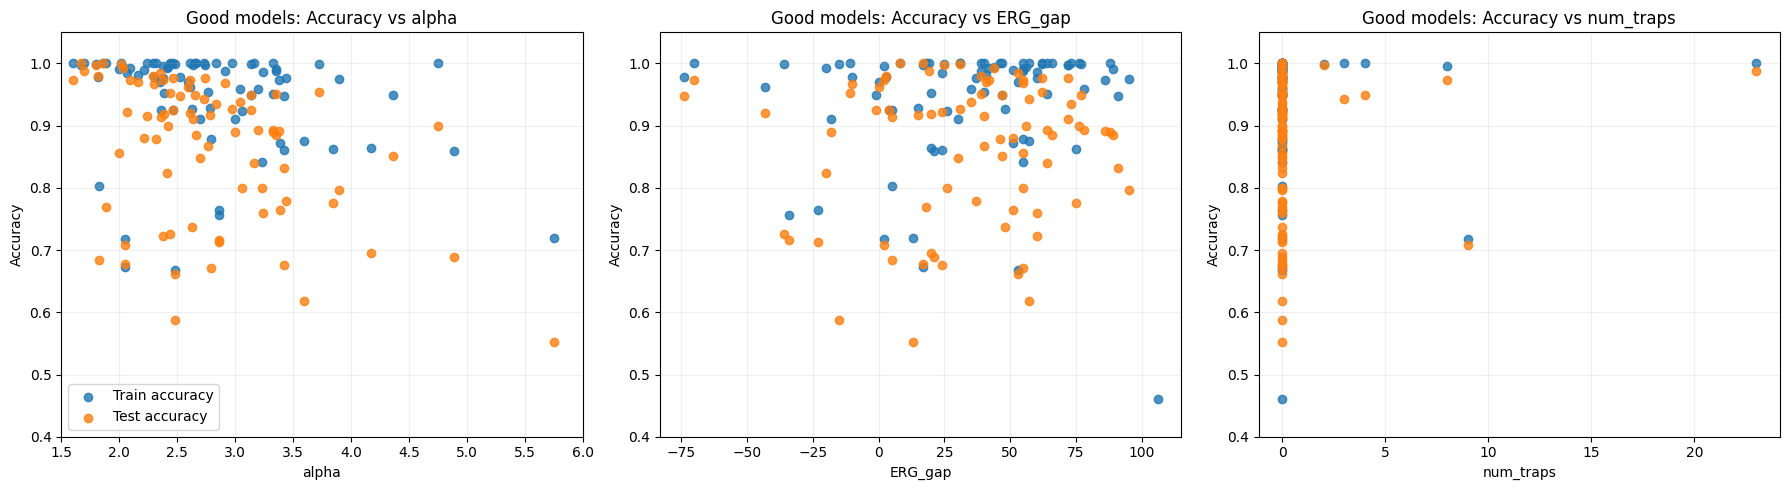

In [85]:
if results_df.empty:
    print("No successful trainings to plot.")
else:
    import matplotlib.pyplot as plt

    plot_df = results_df.sort_values(["source", "dataset_uid"]).copy()

    metrics = ["alpha", "ERG_gap", "num_traps"]
    fig, axes = plt.subplots(1, len(metrics), figsize=(6 * len(metrics), 5), squeeze=False)

    for ax, metric in zip(axes[0], metrics):
        ax.scatter(plot_df[metric], plot_df["train_accuracy"], label="Train accuracy", alpha=0.8)
        ax.scatter(plot_df[metric], plot_df["test_accuracy"], label="Test accuracy", alpha=0.8)
        ax.set_xlabel(metric)
        ax.set_ylabel("Accuracy")
        ax.set_ylim(0.4, 1.05)
        if metric == "alpha":
            ax.set_xlim(1.5, 6)
        ax.set_title(f"Good models: Accuracy vs {metric}")
        ax.grid(alpha=0.2)

    axes[0, 0].legend()
    fig.tight_layout()
    plt.show()


## 8) Train targeted overfit cases for each completed dataset and build aggregated checkpoint


Creating up to 6 overfit cases per completed dataset using modes: ['deep_trees', 'too_many_rounds', 'no_regularization', 'no_subsampling', 'tiny_trainset', 'leakage']
Existing overfit checkpoint rows: 0 | completed pairs: 0 | failed pairs: 0
[dataset 1/82] dataset=openml:115 | case_type=overfit
  [overfit 1/6] mode=deep_trees
    [dataset 1/82] overfit_mode=deep_trees | train_accuracy=1.0000 | test_accuracy=0.9719
  [overfit 2/6] mode=too_many_rounds
    [dataset 1/82] overfit_mode=too_many_rounds | train_accuracy=1.0000 | test_accuracy=0.9748
  [overfit 3/6] mode=no_regularization
    [dataset 1/82] overfit_mode=no_regularization | train_accuracy=1.0000 | test_accuracy=0.9718
  [overfit 4/6] mode=no_subsampling
    [dataset 1/82] overfit_mode=no_subsampling | train_accuracy=1.0000 | test_accuracy=0.9739
  [overfit 5/6] mode=tiny_trainset
    [dataset 1/82] overfit_mode=tiny_trainset | train_accuracy=1.0000 | test_accuracy=0.9167
  [overfit 6/6] mode=leakage
    [dataset 1/82] overfit_

    [dataset 10/82] overfit_mode=leakage | train_accuracy=1.0000 | test_accuracy=1.0000
[dataset 11/82] dataset=openml:504 | case_type=overfit
  [overfit 1/6] mode=deep_trees
    [dataset 11/82] overfit_mode=deep_trees | train_accuracy=0.9815 | test_accuracy=0.9778
  [overfit 2/6] mode=too_many_rounds
    [dataset 11/82] overfit_mode=too_many_rounds | train_accuracy=0.9833 | test_accuracy=0.9655
  [overfit 3/6] mode=no_regularization
    [dataset 11/82] overfit_mode=no_regularization | train_accuracy=0.9824 | test_accuracy=0.9753
  [overfit 4/6] mode=no_subsampling
    [dataset 11/82] overfit_mode=no_subsampling | train_accuracy=0.9833 | test_accuracy=0.9704
  [overfit 5/6] mode=tiny_trainset
    [dataset 11/82] overfit_mode=tiny_trainset | train_accuracy=0.9691 | test_accuracy=0.9507
  [overfit 6/6] mode=leakage
    [dataset 11/82] overfit_mode=leakage | train_accuracy=1.0000 | test_accuracy=1.0000
[dataset 12/82] dataset=openml:821 | case_type=overfit
  [overfit 1/6] mode=deep_trees


    [dataset 26/82] overfit_mode=leakage | train_accuracy=1.0000 | test_accuracy=1.0000
[dataset 27/82] dataset=openml:1181 | case_type=overfit
  [overfit 1/6] mode=deep_trees
SMALL N PL FIT
    [dataset 27/82] overfit_mode=deep_trees | train_accuracy=0.9481 | test_accuracy=0.7915
  [overfit 2/6] mode=too_many_rounds
SMALL N PL FIT
    [dataset 27/82] overfit_mode=too_many_rounds | train_accuracy=0.8814 | test_accuracy=0.8108
  [overfit 3/6] mode=no_regularization
SMALL N PL FIT
    [dataset 27/82] overfit_mode=no_regularization | train_accuracy=0.8446 | test_accuracy=0.8009
  [overfit 4/6] mode=no_subsampling
SMALL N PL FIT
    [dataset 27/82] overfit_mode=no_subsampling | train_accuracy=0.8455 | test_accuracy=0.8107
  [overfit 5/6] mode=tiny_trainset
    [dataset 27/82] overfit_mode=tiny_trainset | train_accuracy=0.8804 | test_accuracy=0.7679
  [overfit 6/6] mode=leakage
    [dataset 27/82] overfit_mode=leakage | train_accuracy=1.0000 | test_accuracy=0.9989
[dataset 28/82] dataset=op

    [dataset 36/82] overfit_mode=leakage | train_accuracy=1.0000 | test_accuracy=1.0000
[dataset 37/82] dataset=openml:962 | case_type=overfit
  [overfit 1/6] mode=deep_trees
    [dataset 37/82] overfit_mode=deep_trees | train_accuracy=0.9981 | test_accuracy=1.0000
  [overfit 2/6] mode=too_many_rounds
    [dataset 37/82] overfit_mode=too_many_rounds | train_accuracy=0.9988 | test_accuracy=0.9975
  [overfit 3/6] mode=no_regularization
    [dataset 37/82] overfit_mode=no_regularization | train_accuracy=0.9981 | test_accuracy=1.0000
  [overfit 4/6] mode=no_subsampling
    [dataset 37/82] overfit_mode=no_subsampling | train_accuracy=0.9981 | test_accuracy=1.0000
  [overfit 5/6] mode=tiny_trainset
SMALL N PL FIT
    [dataset 37/82] overfit_mode=tiny_trainset | train_accuracy=1.0000 | test_accuracy=0.9800
  [overfit 6/6] mode=leakage
SMALL N PL FIT
    [dataset 37/82] overfit_mode=leakage | train_accuracy=1.0000 | test_accuracy=1.0000
[dataset 38/82] dataset=openml:1381 | case_type=overfit
 

    [dataset 40/82] overfit_mode=leakage | train_accuracy=1.0000 | test_accuracy=1.0000
[dataset 41/82] dataset=openml:1024 | case_type=overfit
  [overfit 1/6] mode=deep_trees
    [dataset 41/82] overfit_mode=deep_trees | train_accuracy=1.0000 | test_accuracy=1.0000
  [overfit 2/6] mode=too_many_rounds
    [dataset 41/82] overfit_mode=too_many_rounds | train_accuracy=1.0000 | test_accuracy=1.0000
  [overfit 3/6] mode=no_regularization
    [dataset 41/82] overfit_mode=no_regularization | train_accuracy=1.0000 | test_accuracy=1.0000
  [overfit 4/6] mode=no_subsampling
    [dataset 41/82] overfit_mode=no_subsampling | train_accuracy=1.0000 | test_accuracy=1.0000
  [overfit 5/6] mode=tiny_trainset
SMALL N PL FIT
    [dataset 41/82] overfit_mode=tiny_trainset | train_accuracy=1.0000 | test_accuracy=0.9839
  [overfit 6/6] mode=leakage
SMALL N PL FIT
    [dataset 41/82] overfit_mode=leakage | train_accuracy=0.9996 | test_accuracy=1.0000
[dataset 42/82] dataset=openml:1128 | case_type=overfit


SMALL N PL FIT
    [dataset 42/82] overfit_mode=tiny_trainset | train_accuracy=1.0000 | test_accuracy=0.9320
  [overfit 6/6] mode=leakage
    [dataset 42/82] overfit_mode=leakage | train_accuracy=0.9992 | test_accuracy=0.9968
[dataset 43/82] dataset=openml:846 | case_type=overfit
  [overfit 1/6] mode=deep_trees
    [dataset 43/82] overfit_mode=deep_trees | train_accuracy=0.9909 | test_accuracy=0.8831
  [overfit 2/6] mode=too_many_rounds
    [dataset 43/82] overfit_mode=too_many_rounds | train_accuracy=0.9837 | test_accuracy=0.8889
  [overfit 3/6] mode=no_regularization
    [dataset 43/82] overfit_mode=no_regularization | train_accuracy=0.9937 | test_accuracy=0.8735
  [overfit 4/6] mode=no_subsampling
    [dataset 43/82] overfit_mode=no_subsampling | train_accuracy=0.9728 | test_accuracy=0.9015
  [overfit 5/6] mode=tiny_trainset
SMALL N PL FIT
    [dataset 43/82] overfit_mode=tiny_trainset | train_accuracy=0.9668 | test_accuracy=0.8060
  [overfit 6/6] mode=leakage
    [dataset 43/82] ov

    [dataset 67/82] overfit_mode=leakage | train_accuracy=1.0000 | test_accuracy=0.9880
[dataset 68/82] dataset=openml:1504 | case_type=overfit
  [overfit 1/6] mode=deep_trees
    [dataset 68/82] overfit_mode=deep_trees | train_accuracy=1.0000 | test_accuracy=1.0000
  [overfit 2/6] mode=too_many_rounds


SMALL N PL FIT
    [dataset 68/82] overfit_mode=too_many_rounds | train_accuracy=1.0000 | test_accuracy=1.0000
  [overfit 3/6] mode=no_regularization
    [dataset 68/82] overfit_mode=no_regularization | train_accuracy=1.0000 | test_accuracy=1.0000
  [overfit 4/6] mode=no_subsampling
SMALL N PL FIT
    [dataset 68/82] overfit_mode=no_subsampling | train_accuracy=1.0000 | test_accuracy=1.0000
  [overfit 5/6] mode=tiny_trainset
    [dataset 68/82] overfit_mode=tiny_trainset | train_accuracy=0.9481 | test_accuracy=0.7738
  [overfit 6/6] mode=leakage
    [dataset 68/82] overfit_mode=leakage | train_accuracy=0.9987 | test_accuracy=0.9949
[dataset 69/82] dataset=openml:1097 | case_type=overfit
  [overfit 1/6] mode=deep_trees
    [dataset 69/82] overfit_mode=deep_trees | train_accuracy=0.9250 | test_accuracy=0.9250
  [overfit 2/6] mode=too_many_rounds
    [dataset 69/82] overfit_mode=too_many_rounds | train_accuracy=0.9250 | test_accuracy=0.9250
  [overfit 3/6] mode=no_regularization
    [data

SMALL N PL FIT
    [dataset 70/82] overfit_mode=leakage | train_accuracy=1.0000 | test_accuracy=1.0000
[dataset 71/82] dataset=openml:335 | case_type=overfit
  [overfit 1/6] mode=deep_trees
SMALL N PL FIT
    [dataset 71/82] overfit_mode=deep_trees | train_accuracy=0.9910 | test_accuracy=0.9820
  [overfit 2/6] mode=too_many_rounds
    [dataset 71/82] overfit_mode=too_many_rounds | train_accuracy=0.9932 | test_accuracy=0.9730
  [overfit 3/6] mode=no_regularization
    [dataset 71/82] overfit_mode=no_regularization | train_accuracy=0.9910 | test_accuracy=0.9820
  [overfit 4/6] mode=no_subsampling
    [dataset 71/82] overfit_mode=no_subsampling | train_accuracy=0.9910 | test_accuracy=0.9820
  [overfit 5/6] mode=tiny_trainset
    FAILED overfit case dataset=openml:335 mode=tiny_trainset: Found array with 1 feature(s) (shape=(22, 1)) while a minimum of 2 is required by TruncatedSVD.
  [overfit 6/6] mode=leakage
SMALL N PL FIT
    [dataset 71/82] overfit_mode=leakage | train_accuracy=1.0000 

SMALL N PL FIT
    [dataset 72/82] overfit_mode=leakage | train_accuracy=1.0000 | test_accuracy=0.9730
[dataset 73/82] dataset=openml:1375 | case_type=overfit
  [overfit 1/6] mode=deep_trees
    [dataset 73/82] overfit_mode=deep_trees | train_accuracy=0.9791 | test_accuracy=0.9632
  [overfit 2/6] mode=too_many_rounds
    [dataset 73/82] overfit_mode=too_many_rounds | train_accuracy=0.9757 | test_accuracy=0.9675
  [overfit 3/6] mode=no_regularization
    [dataset 73/82] overfit_mode=no_regularization | train_accuracy=0.9798 | test_accuracy=0.9670
  [overfit 4/6] mode=no_subsampling
    [dataset 73/82] overfit_mode=no_subsampling | train_accuracy=0.9746 | test_accuracy=0.9665
  [overfit 5/6] mode=tiny_trainset
    [dataset 73/82] overfit_mode=tiny_trainset | train_accuracy=0.9833 | test_accuracy=0.9457
  [overfit 6/6] mode=leakage
    [dataset 73/82] overfit_mode=leakage | train_accuracy=0.9999 | test_accuracy=0.9996
[dataset 74/82] dataset=openml:1156 | case_type=overfit
  [overfit 1/6]

    FAILED overfit case dataset=openml:1446 mode=tiny_trainset: Found array with 1 feature(s) (shape=(11, 1)) while a minimum of 2 is required by TruncatedSVD.
  [overfit 6/6] mode=leakage
SMALL N PL FIT
    [dataset 77/82] overfit_mode=leakage | train_accuracy=1.0000 | test_accuracy=1.0000
[dataset 78/82] dataset=keel:banana | case_type=overfit
  [overfit 1/6] mode=deep_trees
    [dataset 78/82] overfit_mode=deep_trees | train_accuracy=0.7157 | test_accuracy=0.7138
  [overfit 2/6] mode=too_many_rounds
SMALL N PL FIT
    [dataset 78/82] overfit_mode=too_many_rounds | train_accuracy=0.7550 | test_accuracy=0.7421
  [overfit 3/6] mode=no_regularization
    [dataset 78/82] overfit_mode=no_regularization | train_accuracy=0.7172 | test_accuracy=0.7075
  [overfit 4/6] mode=no_subsampling
    [dataset 78/82] overfit_mode=no_subsampling | train_accuracy=0.7521 | test_accuracy=0.7537
  [overfit 5/6] mode=tiny_trainset
    [dataset 78/82] overfit_mode=tiny_trainset | train_accuracy=0.6737 | test_

    [dataset 82/82] overfit_mode=leakage | train_accuracy=1.0000 | test_accuracy=1.0000
Saved aggregated checkpoint:
 - /content/drive/MyDrive/xgbwwdata/experiment_checkpoints/random100_xgboost_accuracy_plus_overfit_run04/checkpoint_results_good_plus_overfit.csv
Good rows: 82 | Overfit rows: 492 | Expected overfit rows: 492
Overfit status counts:


,count
status,
completed,446
failed,46


,case_type,overfit_mode,source,dataset_uid,train_accuracy,test_accuracy,accuracy_gap,alpha,ERG_gap,num_traps
77,good,none,keel,keel:banana,0.717243,0.707547,0.009696,2.054009,2.0,9.0
48,good,none,keel,keel:bupa,0.673387,0.677419,-0.004032,2.047812,17.0,0.0
79,good,none,openml,openml:1011,0.970149,0.985294,-0.015145,2.350648,53.0,0.0
40,good,none,openml,openml:1024,0.999106,0.998214,0.000891,1.803256,25.0,2.0
8,good,none,openml,openml:1035,0.802564,0.683673,0.118891,1.823392,5.0,0.0
...,...,...,...,...,...,...,...,...,...,...
297,overfit,leakage,pmlb,pmlb:GAMETES_Heterogeneity_20atts_1600_Het_0.4...,1.000000,1.000000,0.000000,-1.000000,3.0,0.0
294,overfit,no_regularization,pmlb,pmlb:GAMETES_Heterogeneity_20atts_1600_Het_0.4...,0.830469,0.612500,0.217969,NaN,NaN,NaN
295,overfit,no_subsampling,pmlb,pmlb:GAMETES_Heterogeneity_20atts_1600_Het_0.4...,0.859375,0.671875,0.187500,3.163616,3.0,0.0
296,overfit,tiny_trainset,pmlb,pmlb:GAMETES_Heterogeneity_20atts_1600_Het_0.4...,0.718750,0.496875,0.221875,NaN,NaN,NaN


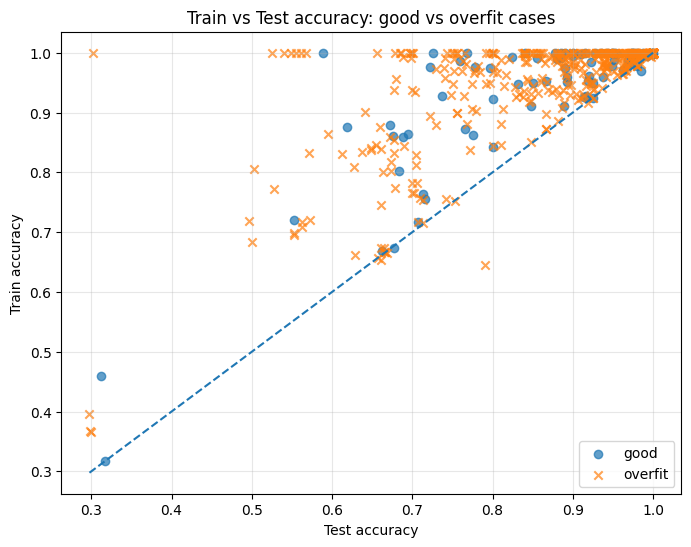

In [86]:
import matplotlib.pyplot as plt

if results_df.empty:
    print("No completed good models. Cannot build overfit comparison set.")
    combined_df = results_df.copy()
    overfit_df = pd.DataFrame()
else:
    good_df = results_df.copy()
    good_df["case_type"] = good_df.get("case_type", "good")
    good_df["overfit_mode"] = good_df.get("overfit_mode", "none")
    if "accuracy_gap" not in good_df.columns:
        good_df["accuracy_gap"] = good_df["train_accuracy"] - good_df["test_accuracy"]

    # Restart-aware overfit checkpointing:
    # - load previously saved overfit rows from CHECKPOINT_AGGREGATED_CSV
    # - skip already completed (dataset_uid, overfit_mode) pairs
    # - persist after every overfit case so long runs can resume exactly
    overfit_cols = [
        "case_type", "dataset_uid", "overfit_mode", "status", "error_message",
        "source", "train_accuracy", "test_accuracy", "accuracy_gap", "alpha", "ERG_gap", "num_traps"
    ]
    existing_overfit_df = pd.DataFrame(columns=overfit_cols)
    if CHECKPOINT_AGGREGATED_CSV.exists():
        existing_combined_df = pd.read_csv(CHECKPOINT_AGGREGATED_CSV)
        if "case_type" in existing_combined_df.columns:
            existing_overfit_df = existing_combined_df[
                existing_combined_df["case_type"].astype(str) == "overfit"
            ].copy()
            if "status" not in existing_overfit_df.columns:
                existing_overfit_df["status"] = "completed"
            if "error_message" not in existing_overfit_df.columns:
                existing_overfit_df["error_message"] = ""

    completed_pairs = set()
    failed_pairs = set()
    if not existing_overfit_df.empty:
        existing_overfit_df["dataset_uid"] = existing_overfit_df["dataset_uid"].astype(str)
        existing_overfit_df["overfit_mode"] = existing_overfit_df["overfit_mode"].astype(str)
        completed_pairs = {
            (uid, mode)
            for uid, mode, status in zip(
                existing_overfit_df["dataset_uid"],
                existing_overfit_df["overfit_mode"],
                existing_overfit_df["status"].astype(str),
            )
            if status == "completed"
        }
        failed_pairs = {
            (uid, mode)
            for uid, mode, status in zip(
                existing_overfit_df["dataset_uid"],
                existing_overfit_df["overfit_mode"],
                existing_overfit_df["status"].astype(str),
            )
            if status == "failed"
        }

    per_dataset_modes = OVERFIT_MODES[:MAX_OVERFIT_CASES]
    expected_total = len(good_df) * len(per_dataset_modes)
    print(
        f"Creating up to {len(per_dataset_modes)} overfit cases per completed dataset "
        f"using modes: {per_dataset_modes}"
    )
    print(
        f"Existing overfit checkpoint rows: {len(existing_overfit_df)} "
        f"| completed pairs: {len(completed_pairs)} | failed pairs: {len(failed_pairs)}"
    )

    # Deduplicate by pair, preferring the latest row if present in existing checkpoint.
    overfit_records = {}
    if not existing_overfit_df.empty:
        for _, r in existing_overfit_df.iterrows():
            key = (str(r.get("dataset_uid")), str(r.get("overfit_mode")))
            overfit_records[key] = r.to_dict()

    total_good = len(good_df)
    for ds_idx, (_, row) in enumerate(good_df.iterrows(), start=1):
        row_data = row.to_dict()
        uid = str(row_data["dataset_uid"])
        print(f"[dataset {ds_idx}/{total_good}] dataset={uid} | case_type=overfit")

        for mode_idx, mode in enumerate(per_dataset_modes, start=1):
            pair = (uid, str(mode))
            print(f"  [overfit {mode_idx}/{len(per_dataset_modes)}] mode={mode}")

            if pair in completed_pairs:
                print(f"    SKIP completed overfit checkpoint pair={pair}")
                continue

            try:
                overfit_result = fit_and_score(
                    row_data,
                    case_type="overfit",
                    overfit_mode=mode,
                    seed_offset=1000 + (ds_idx * 100) + mode_idx,
                )
                overfit_result["status"] = "completed"
                overfit_result["error_message"] = ""
                print(
                    f"    [dataset {ds_idx}/{total_good}] overfit_mode={mode} "
                    f"| train_accuracy={overfit_result['train_accuracy']:.4f} "
                    f"| test_accuracy={overfit_result['test_accuracy']:.4f}"
                )
                overfit_records[pair] = overfit_result
                completed_pairs.add(pair)
                failed_pairs.discard(pair)
            except Exception as e:
                err = str(e)
                print(f"    FAILED overfit case dataset={uid} mode={mode}: {err}")
                fail_row = {
                    "dataset_uid": uid,
                    "source": row_data.get("source", "unknown"),
                    "case_type": "overfit",
                    "overfit_mode": mode,
                    "status": "failed",
                    "error_message": err,
                    "train_accuracy": np.nan,
                    "test_accuracy": np.nan,
                    "accuracy_gap": np.nan,
                    "alpha": np.nan,
                    "ERG_gap": np.nan,
                    "num_traps": np.nan,
                }
                overfit_records[pair] = fail_row
                failed_pairs.add(pair)

            # Persist after every pair update for robust restart behavior.
            overfit_df = pd.DataFrame(list(overfit_records.values()))
            combined_df = pd.concat([good_df, overfit_df], ignore_index=True, sort=False)
            combined_df.to_csv(CHECKPOINT_AGGREGATED_CSV, index=False)

    overfit_df = pd.DataFrame(list(overfit_records.values()))
    combined_df = pd.concat([good_df, overfit_df], ignore_index=True, sort=False)
    combined_df.to_csv(CHECKPOINT_AGGREGATED_CSV, index=False)

    print("Saved aggregated checkpoint:")
    print(" -", CHECKPOINT_AGGREGATED_CSV)
    print(
        "Good rows:",
        len(good_df),
        "| Overfit rows:",
        len(overfit_df),
        "| Expected overfit rows:",
        expected_total,
    )
    if "status" in overfit_df.columns:
        print("Overfit status counts:")
        display(overfit_df["status"].value_counts(dropna=False))

    if not combined_df.empty:
        display(
            combined_df[
                [
                    "case_type", "overfit_mode", "source", "dataset_uid", "train_accuracy", "test_accuracy",
                    "accuracy_gap", "alpha", "ERG_gap", "num_traps"
                ]
            ].sort_values(["case_type", "source", "dataset_uid", "overfit_mode"])
        )

        # Scatter plot: train vs test accuracy
        plt.figure(figsize=(8, 6))
        plot_df = combined_df.copy()
        for case, marker in [("good", "o"), ("overfit", "x")]:
            sub = plot_df[plot_df["case_type"] == case]
            if sub.empty:
                continue
            plt.scatter(
                sub["test_accuracy"],
                sub["train_accuracy"],
                alpha=0.7,
                label=case,
                marker=marker,
            )
        min_acc = np.nanmin([plot_df["test_accuracy"].min(), plot_df["train_accuracy"].min()])
        max_acc = np.nanmax([plot_df["test_accuracy"].max(), plot_df["train_accuracy"].max()])
        plt.plot([min_acc, max_acc], [min_acc, max_acc], linestyle="--")
        plt.xlabel("Test accuracy")
        plt.ylabel("Train accuracy")
        plt.title("Train vs Test accuracy: good vs overfit cases")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()



In [87]:
!head -200 $CHECKPOINT_AGGREGATED_CSV


source,source_dataset_id,dataset_uid,unique_id,name,task_type,experiment_type,n_rows,n_features,n_classes,scan_timestamp_utc,status,error_message,xgboost_params,rounds,train_size,test_size_rows,train_accuracy,test_accuracy,alpha,ERG_gap,num_traps,dataset_name,dataset_openml_id,test_size,accuracy_gap,case_type,overfit_mode,seed_used
openml,115,openml:115,openml|115,"BNG(mfeat-karhunen,nominal,1000000)",classification,multiclass_classification,60000.0,192.0,10.0,2026-02-25T03:41:28.907993+00:00,completed,,"{""colsample_bytree"": 0.9, ""device"": ""cuda"", ""eval_metric"": ""mlogloss"", ""gamma"": 0.0, ""learning_rate"": 0.05, ""max_depth"": 7, ""min_child_weight"": 1.0, ""num_class"": 10, ""objective"": ""multi:softprob"", ""reg_alpha"": 0.1, ""reg_lambda"": 1.0, ""seed"": 42, ""subsample"": 0.9, ""tree_method"": ""hist""}",1200.0,48000.0,12000.0,1.0,0.9740833333333333,1.6012465391295874,-70.0,0.0,"BNG(mfeat-karhunen,nominal,1000000)",,0.2,0.0259166666666667,good,none,42.0
openml,1487,op

Building plots for 7 modes across 82 datasets.


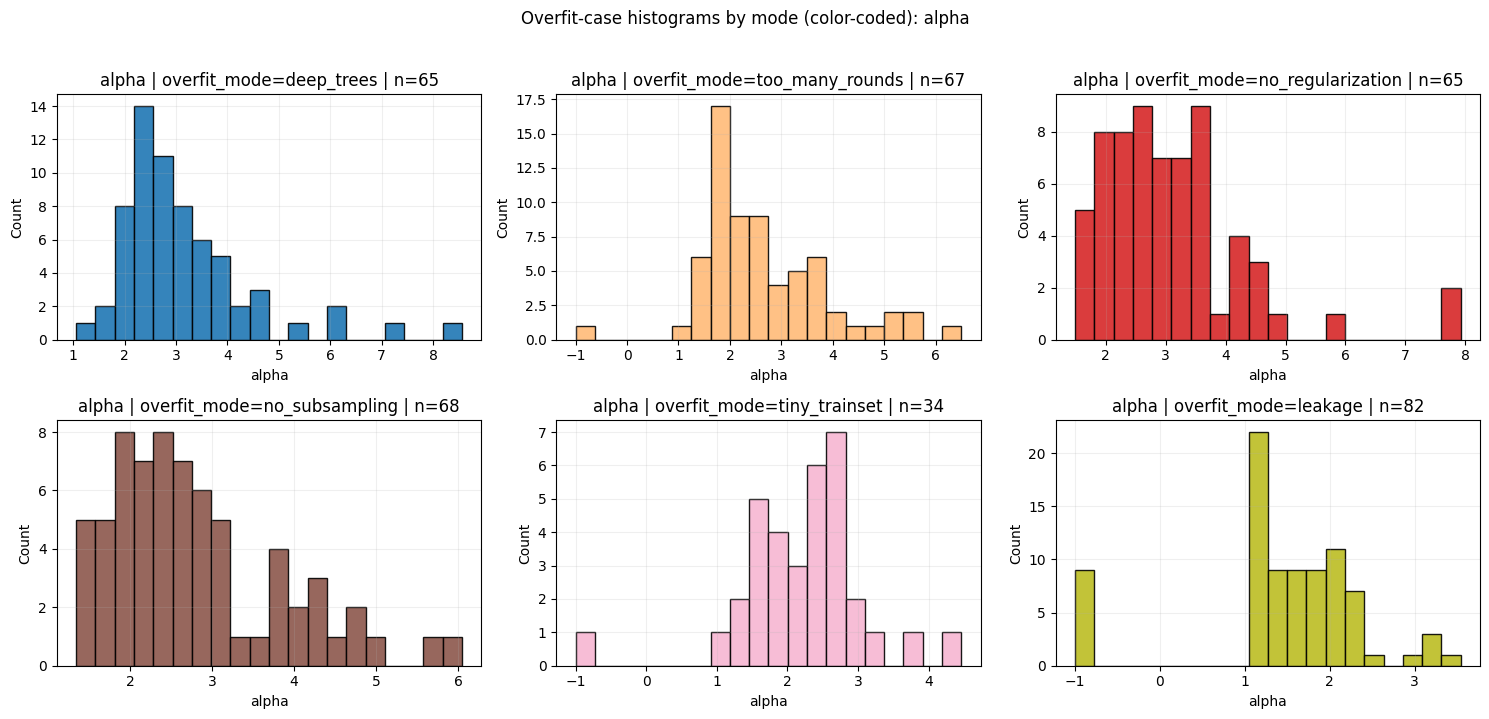

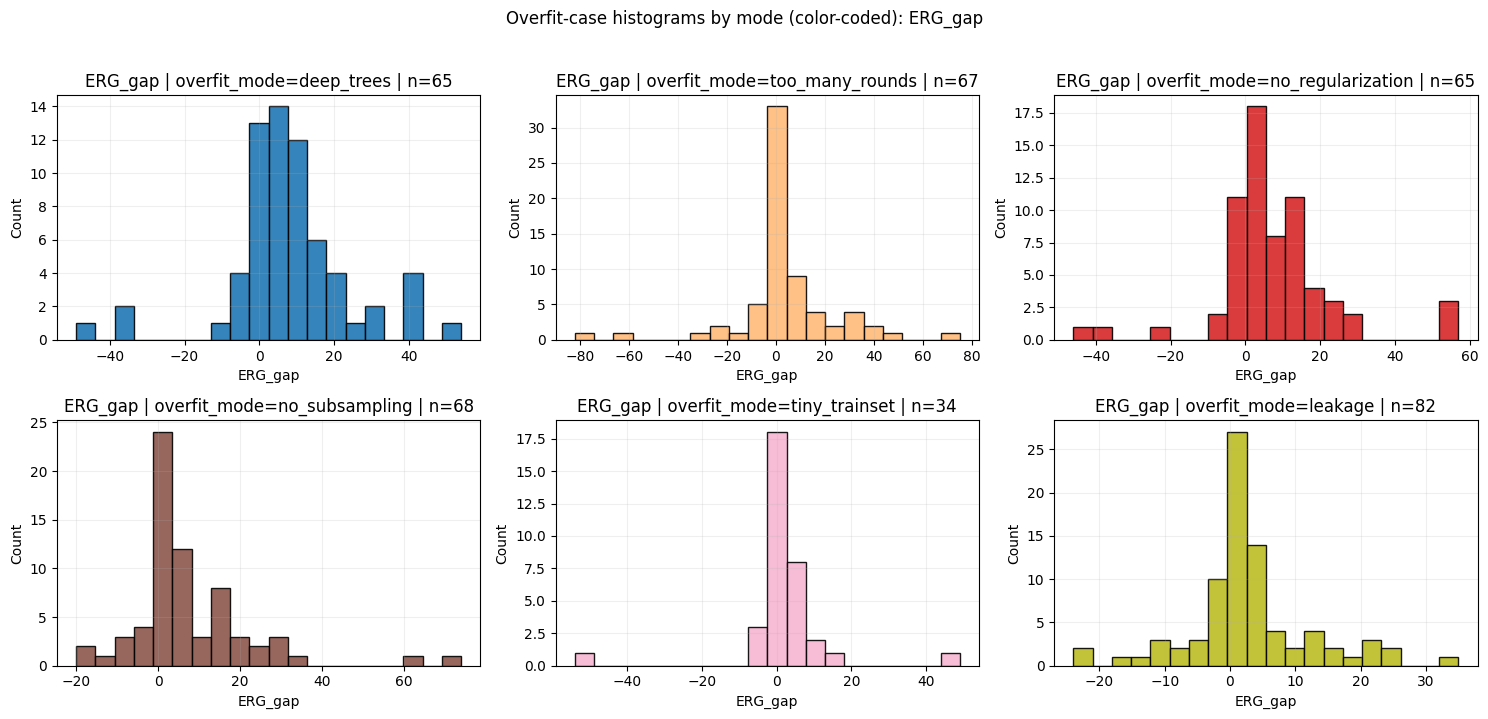

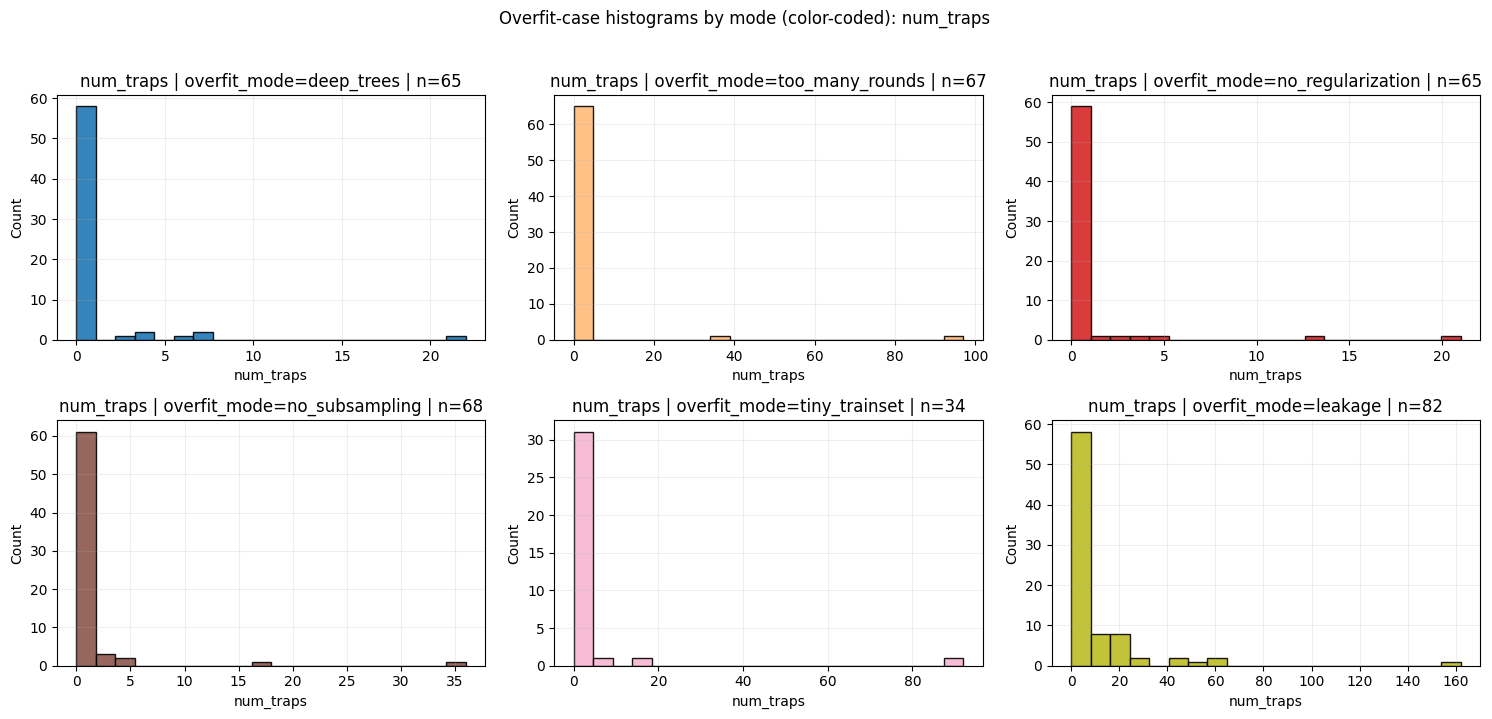

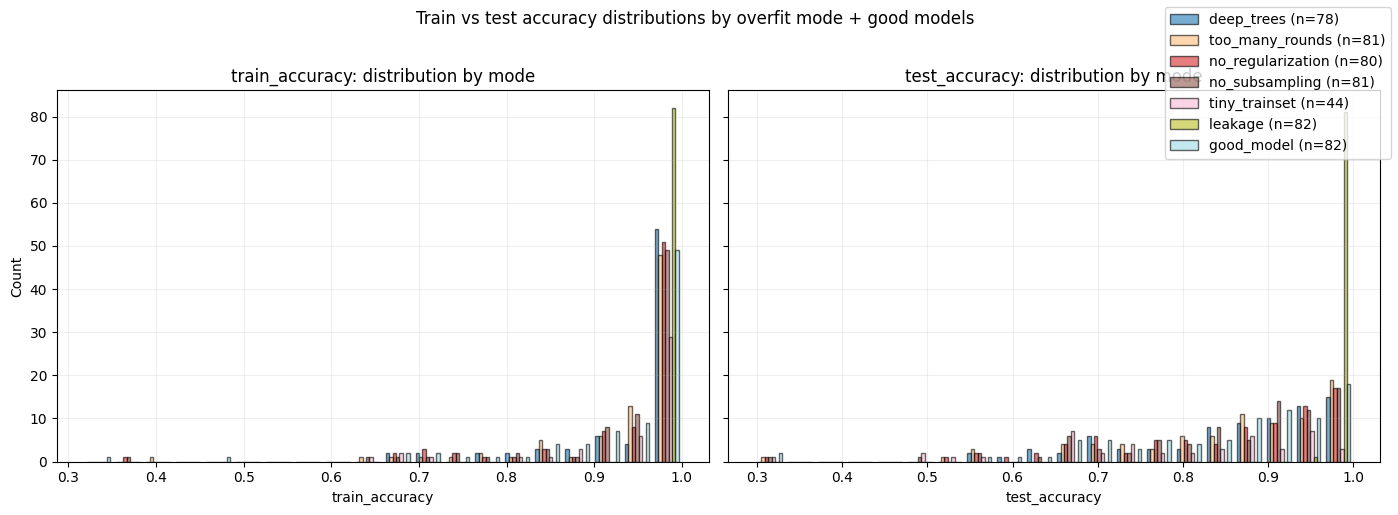

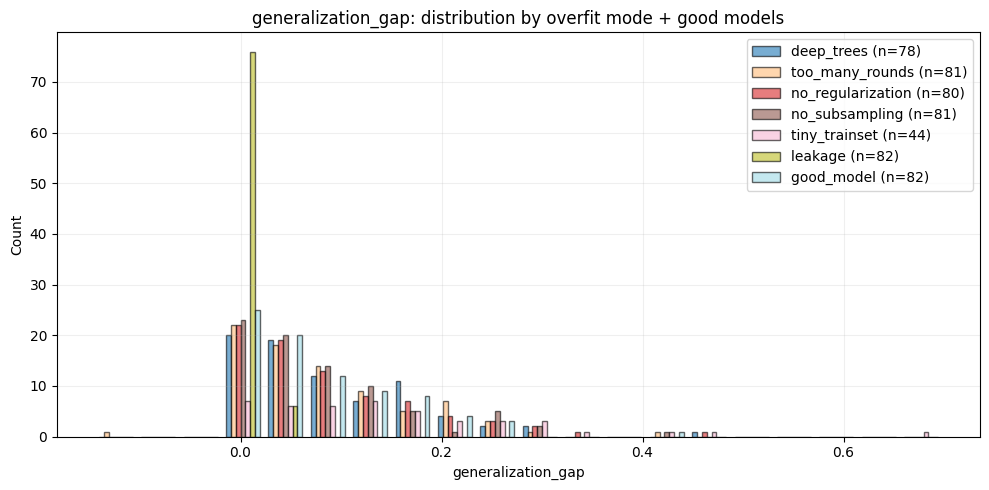

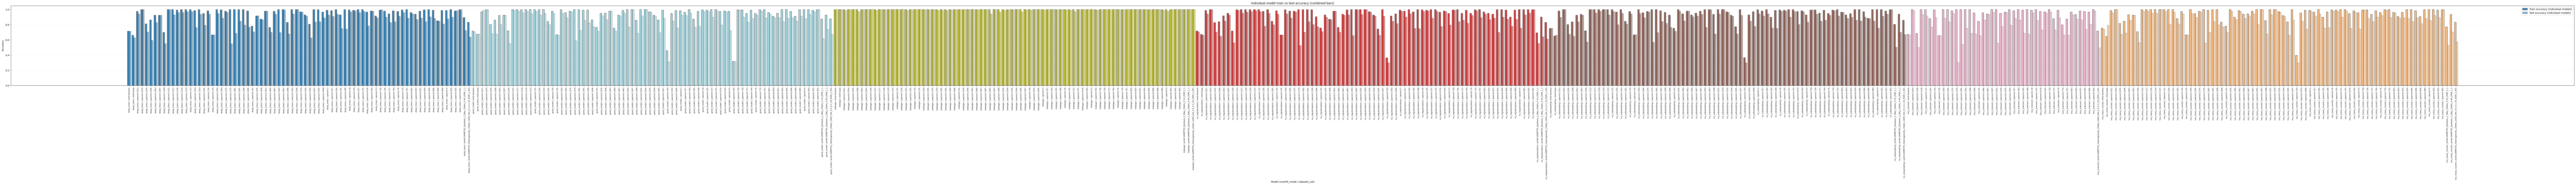

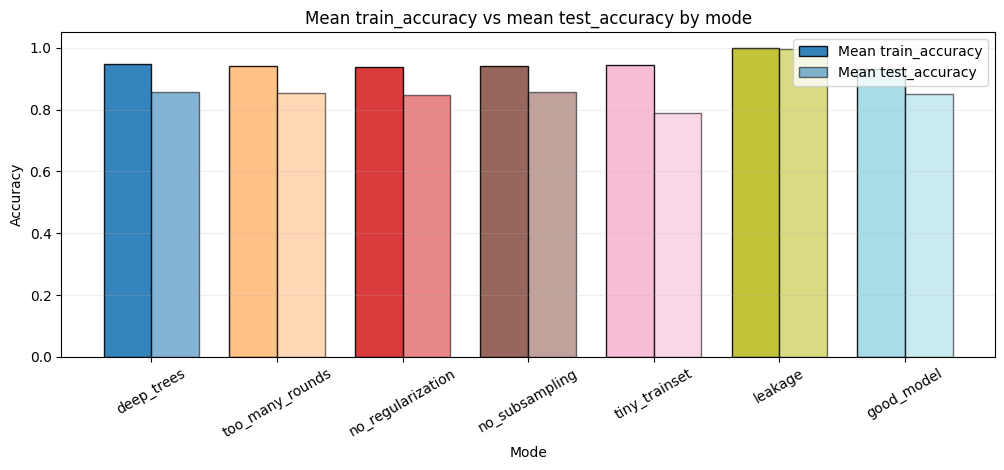

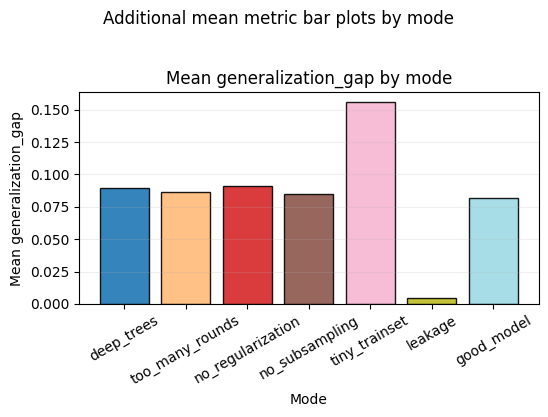

In [88]:
# 9) Histograms of WW metrics + accuracy/gap summaries by case and overfit mode

import math
import numpy as np
import matplotlib.pyplot as plt

if 'combined_df' not in globals() or combined_df.empty:
    print('No combined results available. Run the training/aggregation cells first.')
else:
    plot_df = combined_df.copy()
    plot_df['case_type'] = plot_df.get('case_type', 'good').fillna('good').astype(str)
    plot_df['overfit_mode'] = plot_df.get('overfit_mode', 'none').fillna('none').astype(str)

    # Normalize labels so good models appear as a dedicated mode.
    plot_df.loc[plot_df['case_type'] != 'overfit', 'overfit_mode'] = 'good_model'

    overfit_modes = [
        m for m in OVERFIT_MODES[:MAX_OVERFIT_CASES]
        if m in set(plot_df.loc[plot_df['case_type'] == 'overfit', 'overfit_mode'])
    ]
    modes_in_order = overfit_modes + (['good_model'] if 'good_model' in set(plot_df['overfit_mode']) else [])

    if not modes_in_order:
        print('No overfit or good-model rows available for plotting.')
    else:
        palette = plt.cm.tab20(np.linspace(0, 1, max(len(modes_in_order), 3)))
        mode_colors = {mode: palette[i] for i, mode in enumerate(modes_in_order)}

        print(
            f'Building plots for {len(modes_in_order)} modes '
            f'across {plot_df["dataset_uid"].nunique()} datasets.'
        )

        # --- A) Histograms of WW metrics, color-coded by mode ---
        ww_metrics = ['alpha', 'ERG_gap', 'num_traps']
        hist_only_df = plot_df[plot_df['case_type'] == 'overfit'].copy()

        if hist_only_df.empty:
            print('No overfit rows available for WW metric histograms.')
        else:
            for metric in ww_metrics:
                mode_frames = []
                for mode in overfit_modes:
                    sub = hist_only_df.loc[hist_only_df['overfit_mode'] == mode, [metric]].copy()
                    sub[metric] = pd.to_numeric(sub[metric], errors='coerce')
                    sub = sub.dropna(subset=[metric])
                    mode_frames.append((mode, sub))

                valid_frames = [(m, d) for m, d in mode_frames if not d.empty]
                if not valid_frames:
                    print(f'Skipping {metric}: no numeric values in overfit rows.')
                    continue

                n_modes = len(valid_frames)
                n_cols = min(3, n_modes)
                n_rows = math.ceil(n_modes / n_cols)

                fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 3.5 * n_rows), squeeze=False)
                axes_flat = axes.flatten()

                for ax, (mode, sub) in zip(axes_flat, valid_frames):
                    ax.hist(
                        sub[metric].values,
                        bins=20,
                        alpha=0.9,
                        edgecolor='black',
                        color=mode_colors.get(mode),
                    )
                    ax.set_title(f'{metric} | overfit_mode={mode} | n={len(sub)}')
                    ax.set_xlabel(metric)
                    ax.set_ylabel('Count')
                    ax.grid(alpha=0.2)

                for ax in axes_flat[len(valid_frames):]:
                    ax.axis('off')

                fig.suptitle(f'Overfit-case histograms by mode (color-coded): {metric}', y=1.02)
                fig.tight_layout()
                plt.show()

        # --- B) Histograms for train/test accuracy and generalization gap by mode ---
        metric_candidates = {
            'train_accuracy': ['train_accuracy'],
            'test_accuracy': ['test_accuracy'],
            'generalization_gap': ['accuracy_gap', 'generalization_gap', 'gen_gap'],
        }

        resolved_cols = {}
        for logical_name, candidates in metric_candidates.items():
            for col in candidates:
                if col in plot_df.columns:
                    resolved_cols[logical_name] = col
                    break

        if not resolved_cols:
            print('No accuracy/gap columns found for additional histograms and bar plots.')
        else:
            # Combine train/test accuracy histograms into one figure so the distributions can be compared side-by-side.
            if {'train_accuracy', 'test_accuracy'}.issubset(resolved_cols):
                fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

                for ax, logical_name in zip(axes, ['train_accuracy', 'test_accuracy']):
                    col = resolved_cols[logical_name]
                    hist_vals = []
                    hist_colors = []
                    labels = []

                    for mode in modes_in_order:
                        vals = pd.to_numeric(
                            plot_df.loc[plot_df['overfit_mode'] == mode, col], errors='coerce'
                        ).dropna()
                        if vals.empty:
                            continue
                        hist_vals.append(vals.values)
                        hist_colors.append(mode_colors[mode])
                        labels.append(f'{mode} (n={len(vals)})')

                    if not hist_vals:
                        ax.text(0.5, 0.5, f'No numeric values for {logical_name}', ha='center', va='center')
                        ax.axis('off')
                        continue

                    ax.hist(
                        hist_vals,
                        bins=20,
                        alpha=0.6,
                        label=labels,
                        color=hist_colors,
                        edgecolor='black',
                        stacked=False,
                    )
                    ax.set_xlabel(logical_name)
                    ax.set_title(f'{logical_name}: distribution by mode')
                    ax.grid(alpha=0.2)

                axes[0].set_ylabel('Count')
                handles, labels = axes[0].get_legend_handles_labels()
                if handles:
                    fig.legend(handles, labels, loc='upper right')
                fig.suptitle('Train vs test accuracy distributions by overfit mode + good models', y=1.02)
                fig.tight_layout()
                plt.show()

            for logical_name, col in resolved_cols.items():
                if logical_name in {'train_accuracy', 'test_accuracy'}:
                    continue

                hist_vals = []
                hist_colors = []
                labels = []
                for mode in modes_in_order:
                    vals = pd.to_numeric(
                        plot_df.loc[plot_df['overfit_mode'] == mode, col], errors='coerce'
                    ).dropna()
                    if vals.empty:
                        continue
                    hist_vals.append(vals.values)
                    hist_colors.append(mode_colors[mode])
                    labels.append(f'{mode} (n={len(vals)})')

                if not hist_vals:
                    print(f'Skipping {logical_name}: no numeric values.')
                    continue

                plt.figure(figsize=(10, 5))
                plt.hist(
                    hist_vals,
                    bins=20,
                    alpha=0.6,
                    label=labels,
                    color=hist_colors,
                    edgecolor='black',
                    stacked=False,
                )
                plt.xlabel(logical_name)
                plt.ylabel('Count')
                plt.title(f'{logical_name}: distribution by overfit mode + good models')
                plt.grid(alpha=0.2)
                plt.legend()
                plt.tight_layout()
                plt.show()

            # --- C) Bar plots for individual + mean metrics by mode ---
            agg_cols = list(resolved_cols.values())
            mode_summary = (
                plot_df.groupby('overfit_mode', dropna=False)[agg_cols]
                .mean(numeric_only=True)
                .reindex(modes_in_order)
            )

            if mode_summary.dropna(how='all').empty:
                print('No numeric values available for mode-level bar plots.')
            else:
                # Always combine train/test accuracy bars in the same plots for direct comparison.
                if {'train_accuracy', 'test_accuracy'}.issubset(resolved_cols):
                    train_col = resolved_cols['train_accuracy']
                    test_col = resolved_cols['test_accuracy']

                    indiv_cols = ['dataset_uid', 'overfit_mode', train_col, test_col]
                    indiv_df = plot_df[indiv_cols].copy()
                    indiv_df[train_col] = pd.to_numeric(indiv_df[train_col], errors='coerce')
                    indiv_df[test_col] = pd.to_numeric(indiv_df[test_col], errors='coerce')
                    indiv_df = indiv_df.dropna(subset=[train_col, test_col])

                    if not indiv_df.empty:
                        indiv_df = indiv_df.sort_values(['overfit_mode', 'dataset_uid']).reset_index(drop=True)
                        indiv_df['label'] = (
                            indiv_df['overfit_mode'].astype(str)
                            + ' | '
                            + indiv_df['dataset_uid'].astype(str)
                        )

                        x = np.arange(len(indiv_df))
                        width = 0.38
                        bar_colors = [mode_colors.get(mode, '#999999') for mode in indiv_df['overfit_mode']]

                        fig, ax = plt.subplots(figsize=(max(12, 0.35 * len(indiv_df)), 5.8))
                        ax.bar(
                            x - width / 2,
                            indiv_df[train_col].values,
                            width=width,
                            color=bar_colors,
                            edgecolor='black',
                            alpha=0.9,
                            label='Train accuracy (individual models)',
                        )
                        ax.bar(
                            x + width / 2,
                            indiv_df[test_col].values,
                            width=width,
                            color=bar_colors,
                            edgecolor='black',
                            alpha=0.55,
                            label='Test accuracy (individual models)',
                        )

                        ax.set_xticks(x)
                        ax.set_xticklabels(indiv_df['label'], rotation=90, fontsize=8)
                        ax.set_xlabel('Model (overfit_mode | dataset_uid)')
                        ax.set_ylabel('Accuracy')
                        ax.set_title('Individual model train vs test accuracy (combined bars)')
                        ax.grid(axis='y', alpha=0.2)
                        ax.legend(loc='upper right')
                        fig.tight_layout()
                        plt.show()
                    else:
                        print('No individual rows have both train and test accuracy values for combined bars.')

                    valid_modes = [
                        m for m in modes_in_order
                        if pd.notna(mode_summary.loc[m, train_col]) and pd.notna(mode_summary.loc[m, test_col])
                    ]

                    if valid_modes:
                        x = np.arange(len(valid_modes))
                        width = 0.38
                        train_vals = [mode_summary.loc[m, train_col] for m in valid_modes]
                        test_vals = [mode_summary.loc[m, test_col] for m in valid_modes]
                        bar_colors = [mode_colors[m] for m in valid_modes]

                        fig, ax = plt.subplots(figsize=(max(8, 1.45 * len(valid_modes)), 4.8))
                        ax.bar(
                            x - width / 2,
                            train_vals,
                            width=width,
                            color=bar_colors,
                            edgecolor='black',
                            alpha=0.9,
                            label='Mean train_accuracy',
                        )
                        ax.bar(
                            x + width / 2,
                            test_vals,
                            width=width,
                            color=bar_colors,
                            edgecolor='black',
                            alpha=0.55,
                            label='Mean test_accuracy',
                        )

                        ax.set_xticks(x)
                        ax.set_xticklabels(valid_modes, rotation=30)
                        ax.set_xlabel('Mode')
                        ax.set_ylabel('Accuracy')
                        ax.set_title('Mean train_accuracy vs mean test_accuracy by mode')
                        ax.grid(axis='y', alpha=0.2)
                        ax.legend()
                        fig.tight_layout()
                        plt.show()
                    else:
                        print('No modes have both train and test accuracy values for the combined mean bar chart.')

                remaining_metrics = [
                    (logical_name, col)
                    for logical_name, col in resolved_cols.items()
                    if logical_name not in {'train_accuracy', 'test_accuracy'}
                ]

                if remaining_metrics:
                    fig, axes = plt.subplots(
                        1,
                        len(remaining_metrics),
                        figsize=(5.5 * len(remaining_metrics), 4),
                        squeeze=False,
                    )
                    axes_flat = axes.flatten()

                    for idx, (logical_name, col) in enumerate(remaining_metrics):
                        ax = axes_flat[idx]
                        y = mode_summary[col]
                        x_labels = [m for m in modes_in_order if pd.notna(y.loc[m])]
                        y_vals = [y.loc[m] for m in x_labels]
                        bar_colors = [mode_colors[m] for m in x_labels]

                        ax.bar(x_labels, y_vals, color=bar_colors, edgecolor='black', alpha=0.9)
                        ax.set_title(f'Mean {logical_name} by mode')
                        ax.set_xlabel('Mode')
                        ax.set_ylabel(f'Mean {logical_name}')
                        ax.tick_params(axis='x', rotation=30)
                        ax.grid(axis='y', alpha=0.2)

                    fig.suptitle('Additional mean metric bar plots by mode', y=1.03)
                    fig.tight_layout()
                    plt.show()

